# SuStaIn - adenos only using RFE

In [1]:
import csv
import re
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

import pySuStaIn

/home/daryl/miniforge3/envs/sustain/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
data = pd.read_csv('/home/daryl/Documents/data/radiomics/pysustain_pca_reduced_features_adenos.csv')
# drop the first column (indices)
data = data.drop(data.columns[0], axis=1)
# drop 'malignancy_diagnosis_ascent' column
data = data.drop('malignancy_diagnosis_ascent', axis=1)
# recode finalhisttyp to be binary, 0 if contains 'minimal', otherwise 1
data['finalhisttyp'] = data['finalhisttyp'].apply(lambda x: 0 if 'Minimal' in x else 1)
# rename finalhisttyp to 'invasive'
data = data.rename(columns={'finalhisttyp': 'invasive'})
data.head()

,scan_name,original_shape_MeshVolume,NoduleType,tstg,nstg,mstg,invasive,lymphinvasion,sprdthrairspace,original_glszm_GrayLevelVariance,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glrlm_LongRunEmphasis
0,summit-4673-hjp_Y2-Lesion1.nii.gz,596.458333,NON_SOLID,T1a(mi),N0,Mx,0,Absent,Absent,0.066327,0.867347,1.214286,0.946429,20.250527
1,summit-3573-jqu_Y1_ALWAYS_SCAN_A-Lesion1.nii.gz,354.666667,SOLID,T1b,N0,Mx,1,Present,Present,0.250000,0.500000,2.500000,0.625000,11.226776
2,summit-2734-ajn_Y1_ALWAYS_SCAN_A-Lesion2.nii.gz,1761.750000,PART_SOLID,T1a,N0,Mx,1,Absent,Absent,0.210000,0.580000,3.100000,0.475000,21.684132
3,summit-3355-knn_Y1_ALWAYS_SCAN_A-Lesion5.nii.gz,416.083333,SOLID,T1b,N2,Mx,1,Present,Not reported,0.000000,1.000000,1.000000,1.000000,15.936267
4,summit-9882-rgg_Y0_BASELINE_A-Lesion1.nii.gz,4827.541667,SOLID,T1c,N0,Mx,1,Not reported,Not reported,0.000000,1.000000,1.000000,1.000000,79.695944


In [19]:
data.invasive.value_counts()

1    163
0      3
Name: invasive, dtype: int64

In [14]:
biomarkers = data.columns[9:]
print(biomarkers)

Index(['original_glszm_GrayLevelVariance',
       'original_glszm_GrayLevelNonUniformityNormalized',
       'original_glszm_HighGrayLevelZoneEmphasis',
       'original_glszm_LowGrayLevelZoneEmphasis',
       'original_glrlm_LongRunEmphasis'],
      dtype='object')


## Feature normalisation

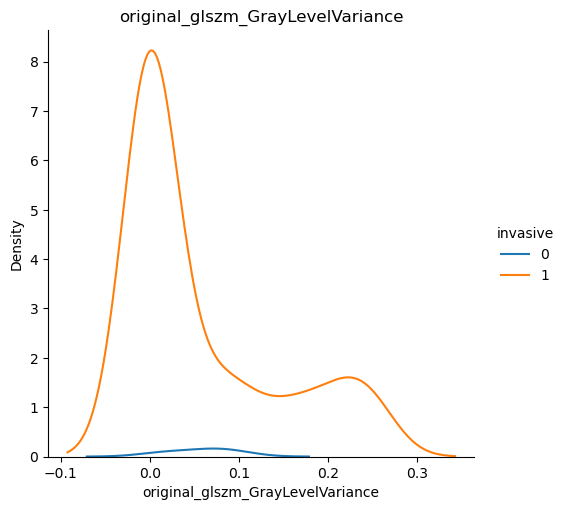

In [20]:
biomarker = biomarkers[0]
sns.displot(data=data, # our dataframe
            x=biomarker, # name of the the distribution we want to plot
            hue='invasive', # the "grouping" variable
            kind='kde') # kind can also be 'hist' or 'ecdf'
plt.title(biomarker)
plt.show()

In [21]:
zdata = pd.DataFrame(data, copy=True)

# for each biomarker
for biomarker in biomarkers:
    mod = smf.ols('%s ~ original_shape_MeshVolume'%biomarker,  # fit a model finding the effect of size on biomarker
                  data=data[data.invasive==0] # fit this model *only* to individuals in the control group
                 ).fit() # fit model    
    #print(mod.summary())
    
    # get the "predicted" values for all subjects based on the control model parameters
    predicted = mod.predict(data[['original_shape_MeshVolume',biomarker]]) 
    
    # calculate our zscore: observed - predicted / SD of the control group residuals
    w_score = (data.loc[:,biomarker] - predicted) / mod.resid.std()
    
    #print(np.mean(w_score[data.Diagnosis==0]))
    #print(np.std(w_score[data.Diagnosis==0]))
    
    # save zscore back into our new (copied) dataframe
    zdata.loc[:,biomarker] = w_score


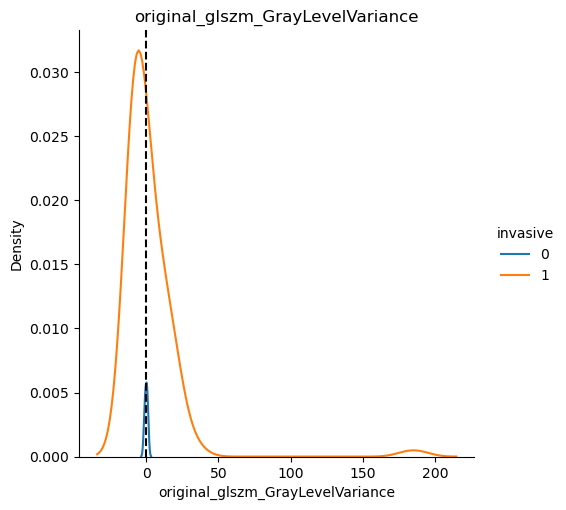

In [24]:
biomarker = biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='invasive',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

## Prepare SuStaIn inputs

In [25]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

print(Z_vals)

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


In [27]:
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 25
N_S_max = 3
N_iterations_MCMC = int(1e5)
output_folder = os.path.join(os.getcwd(), 'output/ASCENTrfe2_adeno')
dataset_name = 'WorkshopOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

In [28]:
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [30]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /home/daryl/Documents/pysustain/pySuStaIn/output/ASCENTrfe2_adeno/pickle_files/WorkshopOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -28733.183292619302


MCMC Iteration: 100%|██████████| 100000/100000 [00:26<00:00, 3794.77it/s]
/home/daryl/Documents/pysustain/pySuStaIn/pySuStaIn/AbstractSustain.py:556: RuntimeWarning: invalid value encountered in true_divide
  total_prob_subtype_norm         = total_prob_subtype        / np.tile(np.sum(total_prob_subtype, 1).reshape(len(total_prob_subtype), 1),        (1, N_S))
/home/daryl/Documents/pysustain/pySuStaIn/pySuStaIn/AbstractSustain.py:557: RuntimeWarning: invalid value encountered in true_divide
  total_prob_stage_norm           = total_prob_stage          / np.tile(np.sum(total_prob_stage, 1).reshape(len(total_prob_stage), 1),          (1, nStages + 1)) #removed total_prob_subtype
/home/daryl/Documents/pysustain/pySuStaIn/pySuStaIn/AbstractSustain.py:560: RuntimeWarning: invalid value encountered in true_divide
  total_prob_subtype_stage_norm   = total_prob_subtype_stage / np.tile(np.sum(np.sum(total_prob_subtype_stage, 1, keepdims=True), 2).reshape(nSamples, 1, 1),(1, nStages + 1, N_S))


Failed to find pickle file: /home/daryl/Documents/pysustain/pySuStaIn/output/ASCENTrfe2_adeno/pickle_files/WorkshopOutput_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem


/home/daryl/Documents/pysustain/pySuStaIn/pySuStaIn/AbstractSustain.py:644: RuntimeWarning: invalid value encountered in true_divide
  p_sequence_norm                 = p_sequence / np.tile(np.sum(p_sequence, 1).reshape(len(p_sequence), 1), (N_S - 1))


 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-27609.90480289]
Overall ML likelihood is [-27609.90480289]


MCMC Iteration: 100%|██████████| 100000/100000 [00:56<00:00, 1768.14it/s]


Failed to find pickle file: /home/daryl/Documents/pysustain/pySuStaIn/output/ASCENTrfe2_adeno/pickle_files/WorkshopOutput_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-27608.71541706]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-27609.90417828]
Overall ML likelihood is [-27608.71541706]


MCMC Iteration: 100%|██████████| 100000/100000 [01:16<00:00, 1309.36it/s]


## SuStaIn output

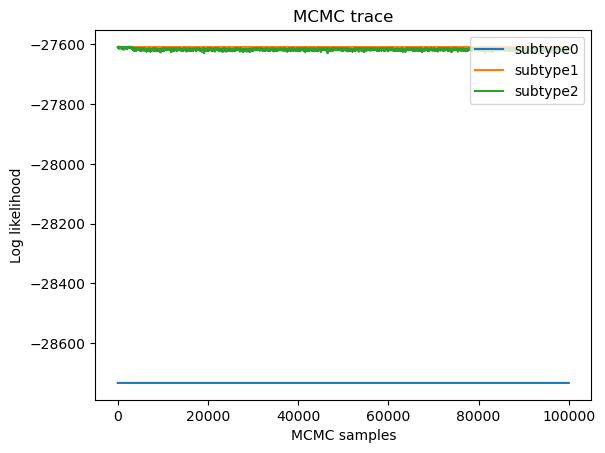

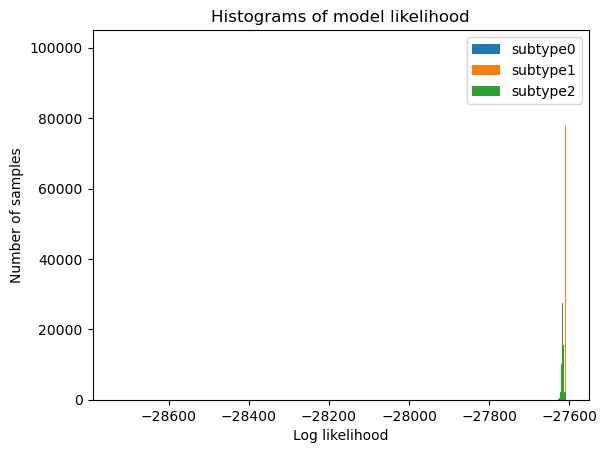

In [31]:
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')

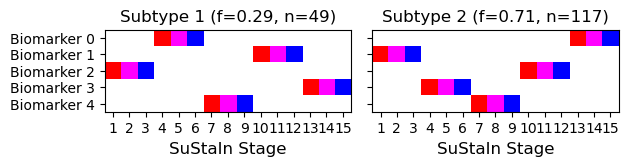

In [32]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 1 # 1 split = 2 subtypes
M = len(zdata) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))

In [33]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 1
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

,scan_name,original_shape_MeshVolume,NoduleType,tstg,nstg,mstg,invasive,lymphinvasion,sprdthrairspace,original_glszm_GrayLevelVariance,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glrlm_LongRunEmphasis,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0
0,summit-4673-hjp_Y2-Lesion1.nii.gz,596.458333,NON_SOLID,T1a(mi),N0,Mx,0,Absent,Absent,-1.033525,1.033525,-1.033525,1.033525,1.033525,0.0,0.949219,1.0,0.358841,9.492194e-01
1,summit-3573-jqu_Y1_ALWAYS_SCAN_A-Lesion1.nii.gz,354.666667,SOLID,T1b,N0,Mx,1,Present,Present,17.395410,-17.395410,34.578025,-34.578025,-1.231312,NaN,NaN,NaN,NaN,NaN
2,summit-2734-ajn_Y1_ALWAYS_SCAN_A-Lesion2.nii.gz,1761.750000,PART_SOLID,T1a,N0,Mx,1,Absent,Absent,16.449284,-16.449284,54.345095,-54.345095,-1.699885,NaN,NaN,NaN,NaN,NaN
3,summit-3355-knn_Y1_ALWAYS_SCAN_A-Lesion5.nii.gz,416.083333,SOLID,T1b,N2,Mx,1,Present,Not reported,-8.294636,8.294636,-7.425884,7.425884,0.128507,0.0,1.000000,6.0,0.547456,1.000000e+00
4,summit-9882-rgg_Y0_BASELINE_A-Lesion1.nii.gz,4827.541667,SOLID,T1c,N0,Mx,1,Not reported,Not reported,1.695723,-1.695723,1.711971,-1.711971,8.711662,1.0,1.000000,9.0,0.692742,5.449213e-08


In [44]:
# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
zdata.loc[:,'ml_subtype'] = zdata.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
zdata.loc[zdata.ml_stage==0,'ml_subtype'] = 0

In [45]:
zdata.ml_subtype.value_counts()

1.0    92
2.0    40
0.0    13
Name: ml_subtype, dtype: int64

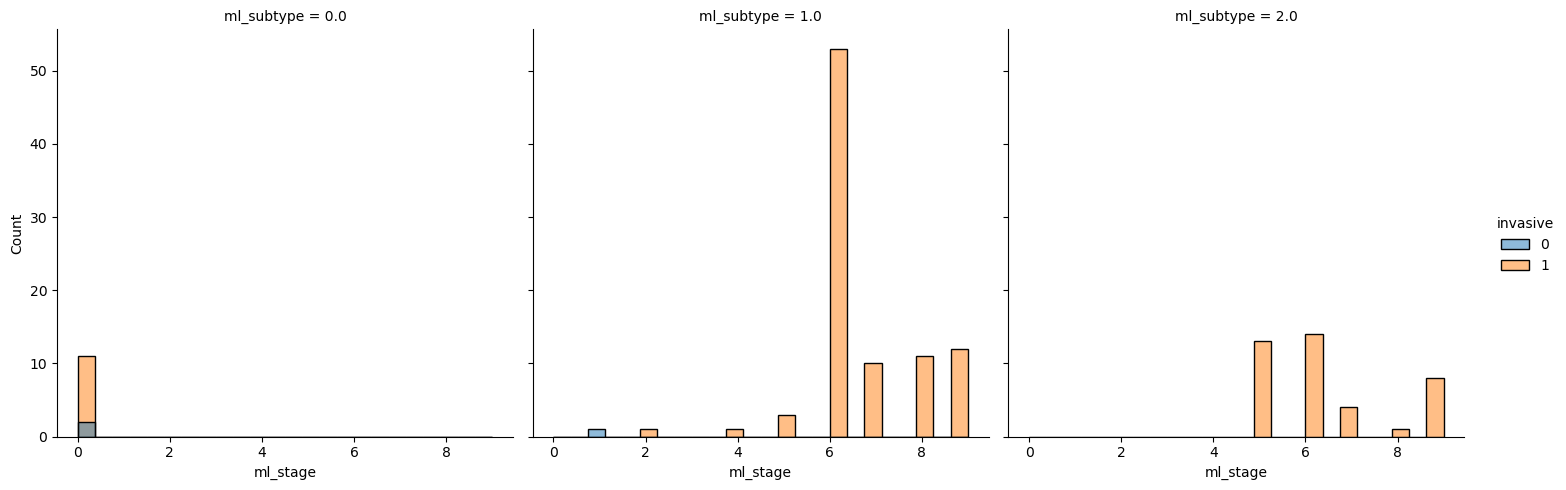

In [46]:
sns.displot(x='ml_stage',hue='invasive',data=zdata,col='ml_subtype')

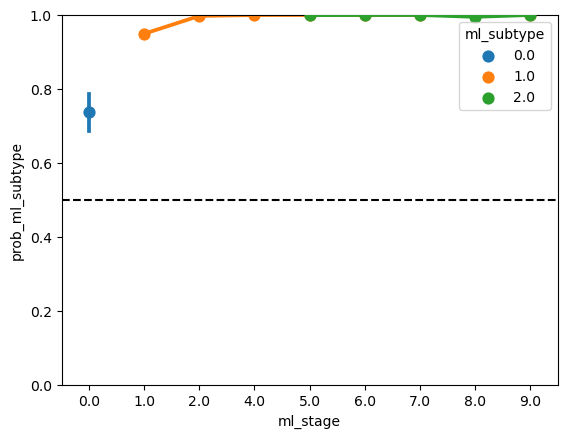

In [47]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata[zdata.ml_subtype>=0]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 subtypes)

## Evaluate relationships

In [51]:
from tableone import TableOne

columns = ['NoduleType', 'tstg', 'nstg', 'mstg', 'invasive', 'lymphinvasion', 'sprdthrairspace']
groupby = ['ml_subtype']

zdata_without_ml0 = zdata[zdata.ml_subtype>0]

mytableone = TableOne(zdata_without_ml0, columns=columns, groupby=groupby, pval=True)
print(mytableone.tabulate(tablefmt = "rst"))

======================  ============  =========  ==========  =========  =========  =========
..                                    Missing    Overall     1.0        2.0        P-Value
======================  ============  =========  ==========  =========  =========  =========
n                                                132         92         40
NoduleType, n (%)       CALCIFIED     0          5 (3.8)     3 (3.3)    2 (5.0)    0.001
..                      NON_SOLID                8 (6.1)     4 (4.3)    4 (10.0)
..                      PART_SOLID               39 (29.5)   18 (19.6)  21 (52.5)
..                      PERIFISSURAL             4 (3.0)     4 (4.3)
..                      SOLID                    76 (57.6)   63 (68.5)  13 (32.5)
tstg, n (%)             T1a           0          21 (15.9)   19 (20.7)  2 (5.0)    0.002
..                      T1a(mi)                  1 (0.8)     1 (1.1)
..                      T1b                      60 (45.5)   46 (50.0)  14 (35.0)
..   

/home/daryl/miniforge3/envs/sustain/lib/python3.7/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/daryl/miniforge3/envs/sustain/lib/python3.7/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),


In [50]:
mytableone.to_excel('/home/daryl/Documents/pysustain/pySuStaIn/plots/tableone.xlsx')

ModuleNotFoundError: No module named 'openpyxl'